In [1]:
import sys
sys.path.insert(0,'/home/djl34/kl_git/scripts')
from notebook_imports import *

mu_list = [2e-09, 6e-09, 2e-08, 6e-08, 2e-07]


/home/djl34/mambaforge/envs/raklette/lib/python3.9/site-packages/dask/dataframe/_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 11.0.0. Please consider upgrading.
  warnings.warn(


# Get some realistic distribution of mu

In [46]:
freq_bin = 9
filename = os.path.join(KL_data_dir, f"whole_genome/freq_bins/freq_bin_{freq_bin}_all.tsv")

df = pd.read_csv(filename, sep = "\t")

In [47]:
df["mu_pergen"] = df["mu"]* per_generation_factor

log_mu_list = np.log10(mu_list)

log_mu_edges_list = log_mu_list[:-1] + np.diff(log_mu_list)/2
log_mu_edges_list = np.insert(log_mu_edges_list, 0, -10)
log_mu_edges_list = np.insert(log_mu_edges_list, len(log_mu_edges_list), -6)
mu_edges_list = np.power(10, log_mu_edges_list)

df["mu_bin"] = pd.cut(df["mu_pergen"], mu_edges_list, labels = mu_list)

df_proportions = df.groupby(["mu_bin"])[["sum"]].sum().reset_index()

df_proportions["prop"] = df_proportions["sum"]/df_proportions["sum"].sum()

# Define Functions

In [50]:
output_dir = "/home/djl34/kl_git/results"

def get_sfs(selection, mu, bin_number, length):
    filename = os.path.join(output_dir, f"SFS_output_v2.6.1_recurrent_slow/gao/multinomial_1000000/multinomial_SFS_Slinear__-{selection}_mu_{mu}_bin_{bin_number}.npy")
    neutral_filename = os.path.join(output_dir, f"SFS_output_v2.6.1_recurrent_slow/gao/multinomial_1000000/multinomial_SFS_Slinear__-0.0_mu_{mu}_bin_{bin_number}.npy")

    sfs_array = np.load(filename)
    neutral_sfs = np.load(neutral_filename)[None, ...]

    data_array = np.random.multinomial(length, sfs_array)[None, ...]
    
    return neutral_sfs, data_array
    


def get_score(bin_number, selection, total_length, transformation = "log", type = "cdf", mu_index = -1, reverse = True):

    #fo mu_index == -1, use the empirical distribution of mu
    if mu_index == -1:
        first = True

        #sample mu
        df_sample = df_proportions.sample(n = total_length, replace = True, weights = "prop")
        df_sample = pd.DataFrame(df_sample.groupby("mu_bin").size()).reset_index()
        
        for mu in mu_list:
            length = df_sample[df_sample["mu_bin"] == mu][0].item()

            # if length == 0:
            #     continue
                
            neutral_sfs, data_array = get_sfs(selection, mu, bin_number, length)        
            if first:
                neutral_sfs_all = neutral_sfs
                data_array_all = data_array
                first = False
            else:
                neutral_sfs_all = np.concatenate((neutral_sfs_all, neutral_sfs), axis=0)
                data_array_all = np.concatenate((data_array_all, data_array), axis=0)
    else:
        mu = mu_list[mu_index]

        neutral_sfs_all, data_array_all = get_sfs(selection, mu, bin_number, total_length)


    winsfs_test = mlr.WinSFS(data = data_array_all, neutral_sfs = neutral_sfs_all)
    
    if type == "Gnocchi":
        return winsfs_test.gnocchi()
    elif type == "ExtraINSIGHT":
        return winsfs_test.extrainsight()   
    elif type == "cdf":
        return winsfs_test.zscore_cdf(transformation = transformation, reverse = reverse)


def calculate_power(sample_size, z_score_cutoff, bin_number, selection, window_length, transformation = "log", type = "cdf", 
                    mu_index = -1, reverse = True):

    list_zscore = []
    for i in range(sample_size):
        list_zscore.append(get_score(bin_number, selection, window_length, transformation, type, mu_index, reverse))

    return sum(np.array(list_zscore) > z_score_cutoff)/sample_size, list_zscore
        

# Compare Binary

Do over realistic mutation rate distribution

In [57]:
selection_list = [0.0, 0.1, 0.01, 0.001]
window_length_list = [1000] 
mu_index_list = range(5)
mu_index_list = [-1]

list_of_list_power = []
list_of_list_zscore = []

# window_length = 1000
window_num = 500

for window_length in window_length_list:
    for selection in selection_list:
        print(selection)
        for mu_index in mu_index_list:

            method_name = "sum(log(p)): 2 bins"
            power, list_zscore = calculate_power(window_num, 2, 2, selection, window_length = window_length, transformation = "log", 
                                                 mu_index = mu_index, reverse = False)
            list_of_list_power.append([power, selection, mu_list[mu_index], window_length, method_name])
            for zscore in list_zscore:
                list_of_list_zscore.append([zscore, selection, mu_list[mu_index], window_length, method_name])
        
            power, list_zscore = calculate_power(window_num, 2, 2, selection, window_length = window_length, transformation = "none", 
                                                 mu_index = mu_index, reverse = False)
            list_of_list_power.append([power, selection, mu_list[mu_index], window_length, "sum(p): 2 bins"])
            for zscore in list_zscore:
                list_of_list_zscore.append([zscore, selection, mu_list[mu_index], window_length, "sum(p): 2 bins"])
        
            power, list_zscore = calculate_power(window_num, 2, 2, selection, window_length = window_length, transformation = "none", 
                                                 type = "Gnocchi", mu_index = mu_index)
            list_of_list_power.append([power, selection, mu_list[mu_index], window_length, "Gnocchi"])
            for zscore in list_zscore:
                list_of_list_zscore.append([zscore, selection, mu_list[mu_index], window_length, "Gnocchi"])

            
            power, list_zscore = calculate_power(window_num, 2, 2, selection, window_length = window_length, transformation = "none", 
                                                 type = "ExtraINSIGHT", mu_index = mu_index)
            list_of_list_power.append([power, selection, mu_list[mu_index], window_length, "ExtraINSIGHT"])
            for zscore in list_zscore:
                list_of_list_zscore.append([zscore, selection, mu_list[mu_index], window_length, "ExtraINSIGHT"])
 

df = pd.DataFrame(list_of_list_power, columns=["power", "selection", "mu", "window length", "type"])
df_zscore = pd.DataFrame(list_of_list_zscore, columns=["zscore", "selection", "mu", "window length", "type"])

0.0
0.1
0.01
0.001


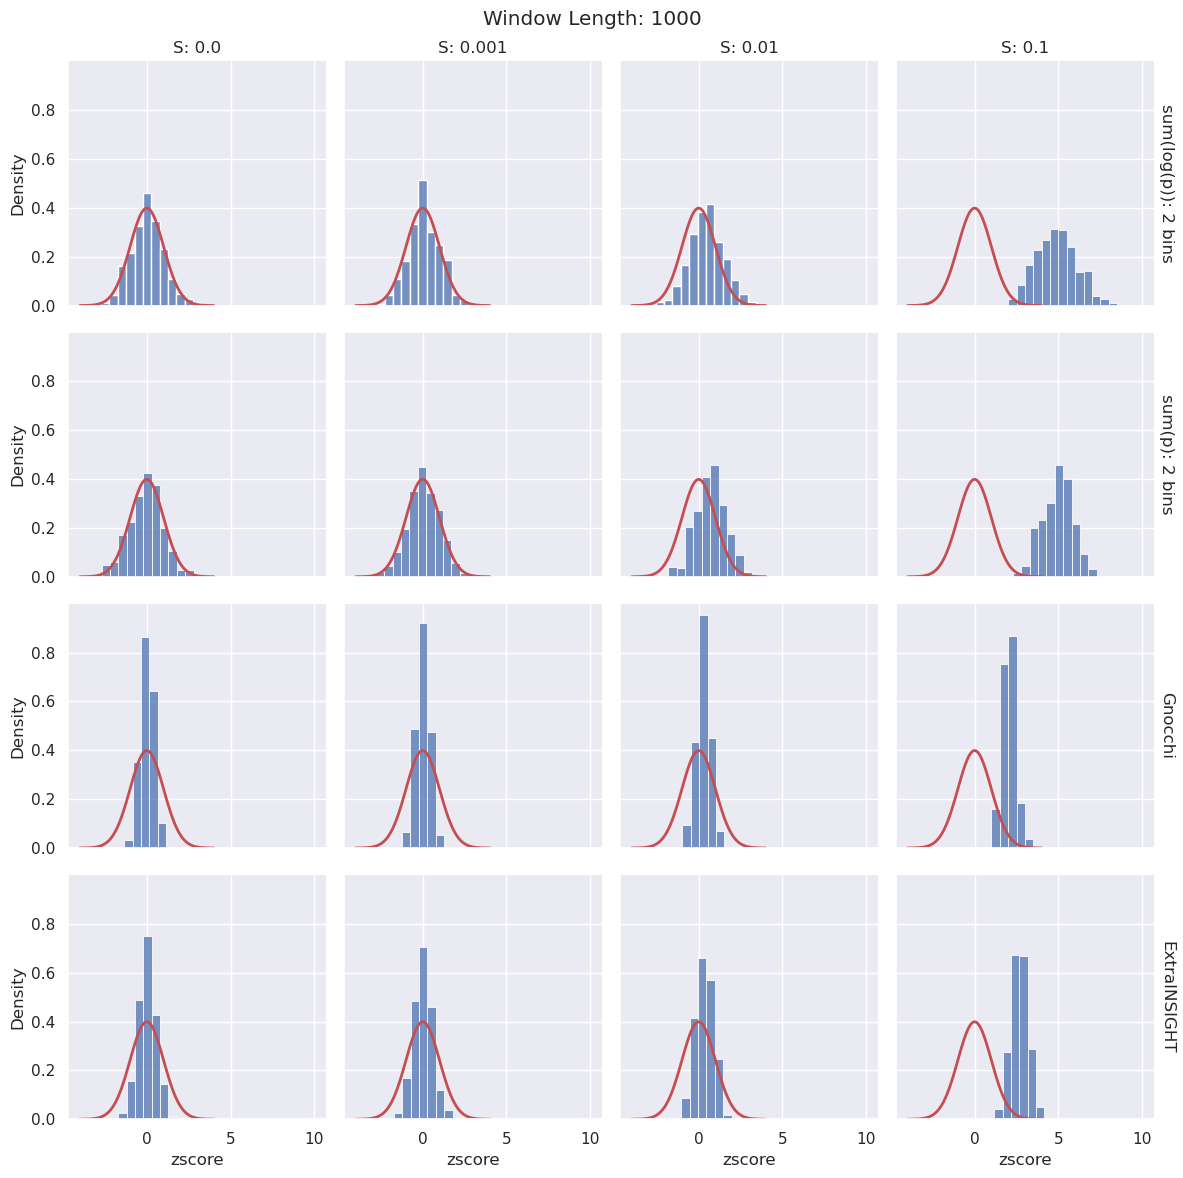

In [58]:
sns.set_theme(style="darkgrid")
g = sns.FacetGrid(df_zscore, col="selection", row="type", height=3, margin_titles=True)

g.map(sns.histplot, "zscore", binwidth=0.5, kde=False, stat='density', label='samples')

g.set_titles(col_template="S: {col_name}", row_template="{row_name}")

g.fig.suptitle(f'Window Length: {window_length}')

def standard_normal(*args, **kwargs):
    # x0, x1 = ax.get_xlim()  # extract the endpoints for the x-axis
    x_pdf = np.linspace(-4, 4, 100)
    y_pdf = scipy.stats.norm.pdf(x_pdf)

    plt.plot(x_pdf, y_pdf, 'r', lw=2, label='pdf')   

g.map(standard_normal)

plt.savefig("power_analysis_binary_zscore_plot.svg", format="svg", bbox_inches="tight")

# Compare 9 bin vs binary

In [64]:
list(range(-1, 5))

[-1, 0, 1, 2, 3, 4]

In [ ]:
selection_list = [0.0, 0.1, 0.03, 0.01, 0.003, 0.001]
window_length_list = [20, 100, 500, 2500] 

list_of_list_power = []
list_of_list_zscore = []

window_num = 500

for window_length in window_length_list:
    print(window_length)
    for selection in selection_list:
        print(selection)
        for mu_index in range(-1, 5):

            for bin_num in [2, 9]:
    
                power, list_zscore = calculate_power(window_num, 2, bin_num, selection, window_length = window_length, 
                                                     transformation = "log", mu_index = mu_index)

                if mu_index == -1:
                    mu_name = "Empirical Distribution"
                else:
                    mu_name = mu_list[mu_index]
                
                list_of_list_power.append([power, selection, mu_name, window_length, f"sum(log(p)): {bin_num} bins"])
                for zscore in list_zscore:
                    list_of_list_zscore.append([zscore, selection, mu_name, window_length, f"sum(log(p)): {bin_num} bins"])

                
                power, list_zscore = calculate_power(window_num, 2, bin_num, selection, window_length = window_length, transformation = "none", 
                                                    mu_index = mu_index)
                list_of_list_power.append([power, selection, mu_name, window_length, f"sum(p): {bin_num} bins"])
                for zscore in list_zscore:
                    list_of_list_zscore.append([zscore, selection, mu_name, window_length, f"sum(p): {bin_num} bins"])
        
df = pd.DataFrame(list_of_list_power, columns=["power", "selection", "mu", "window length", "type"])
df_zscore = pd.DataFrame(list_of_list_zscore, columns=["zscore", "selection", "mu", "window length", "type"])

20
0.0
0.1
0.03
0.01
0.003
0.001
100
0.0
0.1


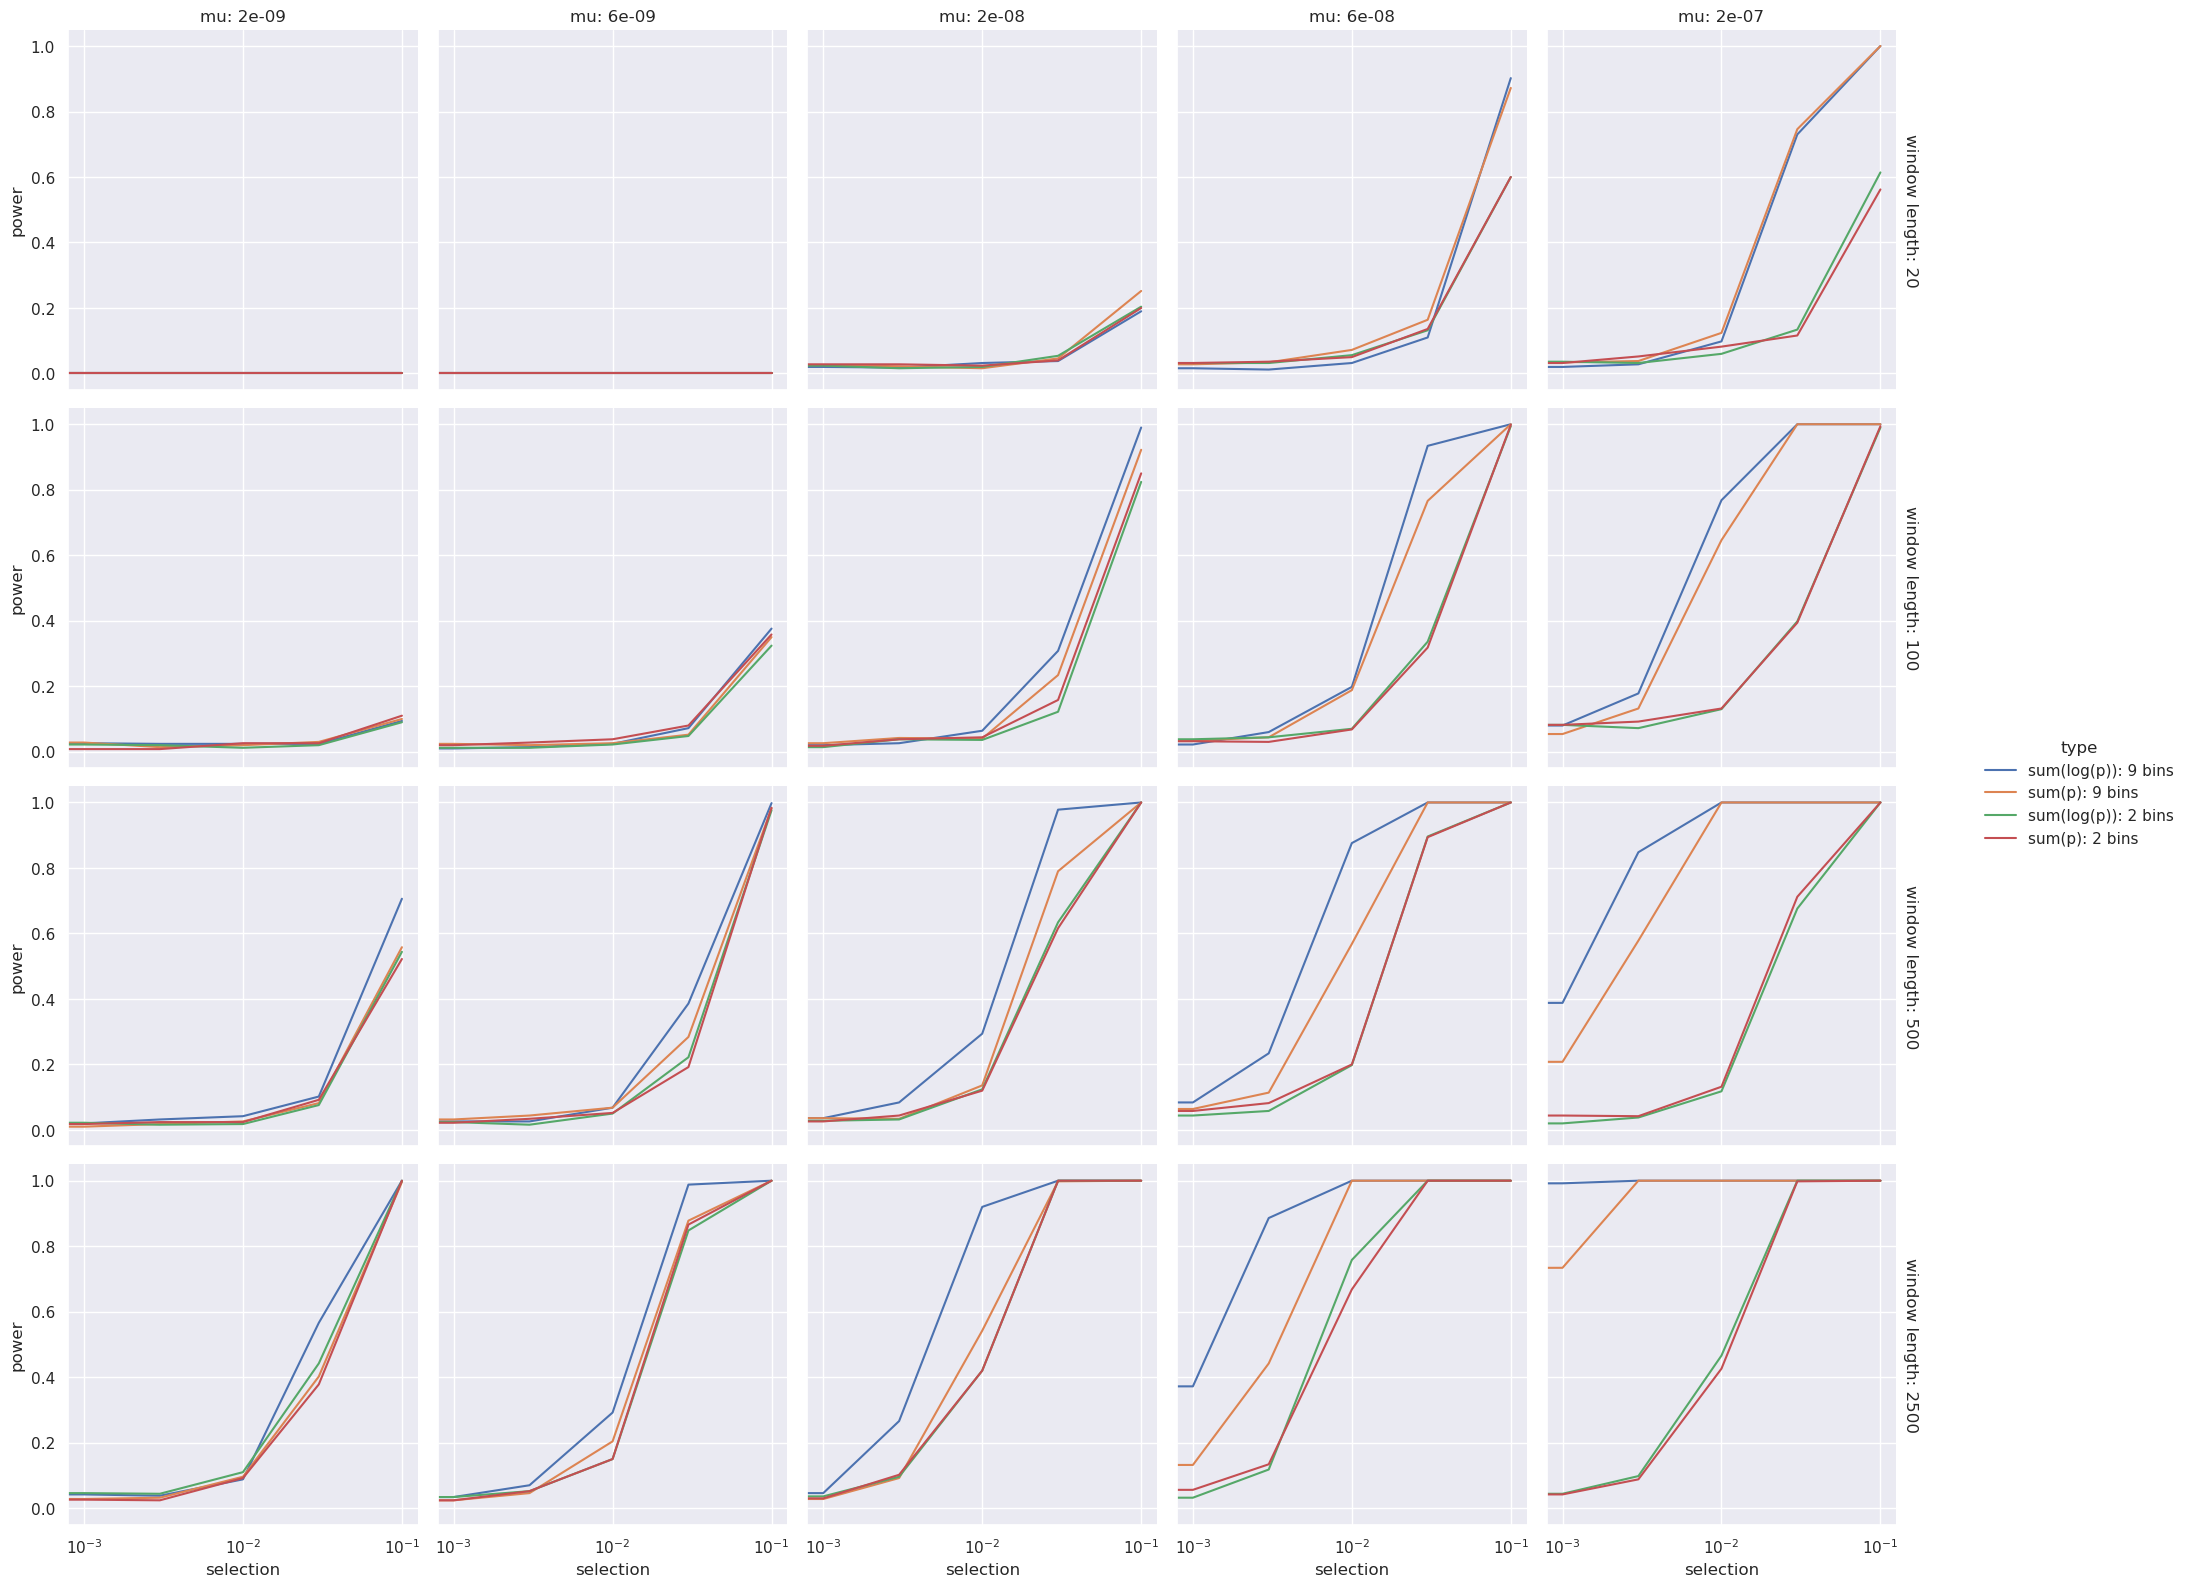

In [62]:
sns.set_theme(style="darkgrid")

# type_list = ["sum(log(p)): 9 bins", "sum(p): 9 bins", "sum(log(p)): 2 bins", "Gnocchi/extraInsight"]
# df_plot = df[df["type"].isin(type_list)]
df_plot = df

# g = sns.FacetGrid(df_zscore, col="mu", row="type", height=3, margin_titles=True)
g = sns.FacetGrid(df_plot, col="mu", row="window length", height=4, margin_titles=True, hue = "type")

g.map(sns.lineplot, "selection", "power")

g.set_titles(col_template="mu: {col_name}", row_template="window length: {row_name}")
g.set(xscale="log")
g.add_legend()
# g.set_titles(col_template="S: {col_name}", row_template="{row_name}")

# g.fig.suptitle(f'Window Length: {window_length}')
plt.savefig("power_analysis_mu_windowlength.svg", format="svg", bbox_inches="tight")